# Segmentação das imagens EP3.1 

Os notebooks também estão no repositório MAC5768 no [Github](https://github.com/iblucher/MAC5768), e os datasets estão na pasta `ep3` no [Google Drive](https://drive.google.com/drive/folders/1DtkTzyPvNXYur2LldKeOHN6mOhBy2t_-?usp=sharing).

In [2]:
import os
from collections import defaultdict
from pathlib import Path

from dataclasses import dataclass

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from skimage import exposure, img_as_ubyte, img_as_bool, io 
from skimage.filters import threshold_otsu, try_all_threshold
from skimage.measure import label, regionprops
from skimage.transform import resize

In [3]:
EXAMPLE_IMAGE_PATH = Path('ground_truth') / 'brush' / 'gt_IMG_1431.JPG'

example_img = io.imread(EXAMPLE_IMAGE_PATH)

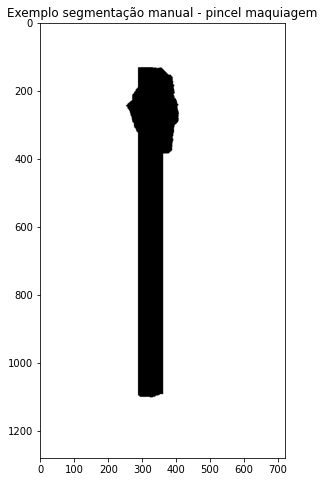

In [5]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

ax.imshow(example_img, cmap='gray')
ax.set_title('Exemplo segmentação manual - pincel maquiagem');

## Thresholding 

Para realizar a segmentação da imagem foi usado um método de thresholding implementado no `scikit-image` chamado `threshold_otsu`. Olhando alguns exemplos com a função `try_all_threshold`, foi possível observar que esse performava bem com as imagens em níveis de cinza.

In [13]:
ORIGINAL_IMAGE_PATH = Path('original_gray_dataset/') / 'brush' / 'IMG_1431.JPG'

original_img = io.imread(ORIGINAL_IMAGE_PATH)

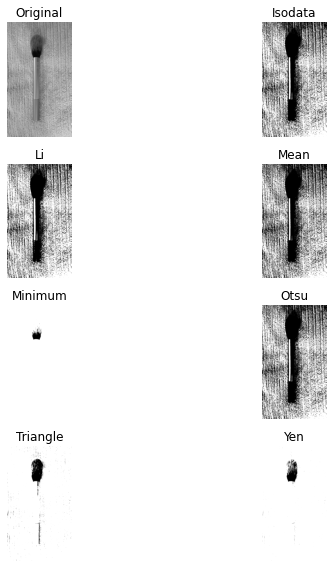

In [15]:
try_all_threshold(original_img, figsize=(10, 8), verbose=False);

In [16]:
def threshold_segmentation(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    
    return binary

In [17]:
ORIGINAL_GRAY_DATASET_PATH = Path('original_gray_dataset/')
SEGMENTED_DATASET_PATH = Path('segmented_dataset')

for filename in ORIGINAL_GRAY_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        segmented_path = f'{SEGMENTED_DATASET_PATH}/{object_class}'

        os.makedirs(segmented_path, exist_ok=True)
        
        img = io.imread(filename)
        segmented_img = threshold_segmentation(img)
        uint8_segmented_img = img_as_ubyte(segmented_img)
        io.imsave(f'{segmented_path}/{tail}', uint8_segmented_img)

No caso da imagem exemplo a segmentação não performou de forma ideal, devido à presença de luz e sombra na imagem, o que fez com que parte do fundo ficasse escuro e o objeto ficasse em pouca evidência.

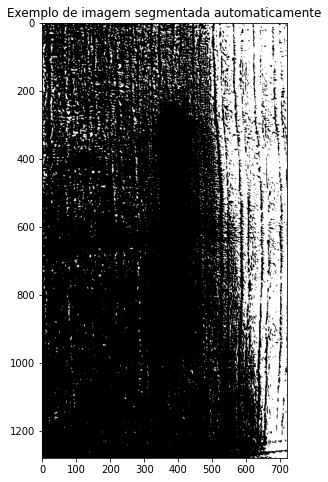

In [21]:
seg_fig = plt.figure(figsize=(12, 8))
seg_ax = seg_fig.add_subplot(111)

seg_ax.imshow(segmented_img, cmap='gray')
seg_ax.set_title('Exemplo de imagem segmentada automaticamente');

## Cortar imagem na Feret Box

Para encontrar a bounding box das imagens foram usados métodos do `scikit-image` para identificar regiões com objetos na imagem. A região com maior área foi a determinada como a região com objeto, e assim obtemos as coordenadas da bounding box. 

Inicialmente foram calculadas as boxes das imagens segmentadas manualmente. Usando as boxes para as imagens segmentadas manualmente temos como calcular a caixa "média" para as imagens de uma determinada classe de objeto. Assim, se o algoritmo não funcionar em uma imagem segmentada usando thresholding podemos cortar a bounding box dela usando a caixa média da classe.

In [6]:
object_class_dimensions = defaultdict(list)
def compute_bounding_box_img(img, object_class, manual_seg=False):
    minr, maxr, minc, maxc = compute_bounding_box_dimensions(img)
               
    if manual_seg:    
        object_class_dimensions[object_class].append([minr, maxr, minc, maxc])    
        
    if not manual_seg and maxr == 1280 and maxc == 720:
        minr, maxr, minc, maxc = average_object_dims[object_class]
    
    box_img = img[minr:maxr, minc:maxc]

    return ~box_img


def compute_bounding_box_dimensions(img):
    img = img < 255  # make image binary (False = white, True = black)
    
    label_image = label(img)
    
    area = 0
    minr, minc, maxr, maxc = np.zeros(4)
    
    for region in regionprops(label_image):
        if region.area >= 100:
            new_minr, new_minc, new_maxr, new_maxc = region.bbox
            new_area = (new_maxr - new_minr) * (new_maxc - new_minc)
            if new_area > area:
                area = new_area
                minr, minc, maxr, maxc = new_minr, new_minc, new_maxr, new_maxc
                
    return minr, maxr, minc, maxc

In [7]:
def flip_binary_img(img):
    """Have the object be black and the background be white."""
    img = img < 255
    
    r, c = img.shape
    true_sum = img.sum()
    
    if true_sum / (r * c) > 0.5:
        return ~img
        
    return img

In [8]:
GROUND_TRUTH_DATASET_PATH = Path('ground_truth/')
GROUND_TRUTH_FERET_BOX_DATASET_PATH = Path('ground_truth_feret_box/')

for filename in GROUND_TRUTH_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        
        box_path = f'{GROUND_TRUTH_FERET_BOX_DATASET_PATH}/{object_class}'

        os.makedirs(box_path, exist_ok=True)
        
        img = io.imread(filename)
        feret_box_img = compute_bounding_box_img(img, object_class, True)
        feret_box_flipped = flip_binary_img(feret_box_img)
        uint8_feret_box_img = img_as_ubyte(feret_box_flipped)
        io.imsave(f'{box_path}/{tail}', uint8_feret_box_img)

In [9]:
average_object_dims = {}

for k, v in object_class_dimensions.items():
    average_object_dims[k] = [int(np.mean(x)) for x in zip(*v)]

In [10]:
SEGMENTED_DATASET_PATH = Path('segmented_dataset')
SEGMENTED_FERET_BOX_DATASET_PATH = Path('segmented_feret_box/')

for filename in SEGMENTED_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        box_path = f'{SEGMENTED_FERET_BOX_DATASET_PATH}/{object_class}'

        os.makedirs(box_path, exist_ok=True)
        
        img = io.imread(filename)
        feret_box_img = compute_bounding_box_img(img, object_class, False)
        feret_box_flipped = flip_binary_img(feret_box_img)
        uint8_feret_box_img = img_as_ubyte(feret_box_flipped)
        io.imsave(f'{box_path}/{tail}', uint8_feret_box_img, check_contrast=False)

In [22]:
EXAMPLE_IMAGE_GT_BOX_PATH = Path('ground_truth_feret_box/') / 'hand_sanitizer' / 'gt_IMG_0829.JPG'
example_gt_box_img = io.imread(EXAMPLE_IMAGE_GT_BOX_PATH)

EXAMPLE_IMAGE_SEG_BOX_PATH = Path('segmented_feret_box/') / 'hand_sanitizer' / 'IMG_0829.JPG'
example_seg_box_img = io.imread(EXAMPLE_IMAGE_SEG_BOX_PATH)

É possível ver abaixo a diferença da segmentação manual e automática na mesma imagem. A segmentação automática teve dificuldade em separar o fundo com textura (toalha cria sombras) e o rótulo do álcool gel (que está em branco).

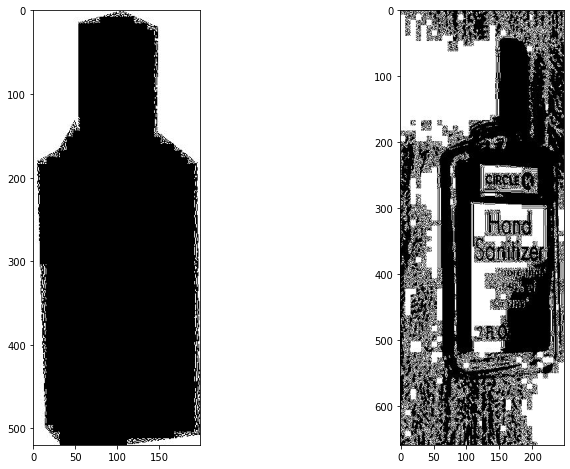

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

axes[0].imshow(example_gt_box_img, cmap='gray')
axes[1].imshow(example_seg_box_img, cmap='gray');

## Relatório de performance da segmentação por threshold

Feita a segmentação automática é posível verificar a performance do algoritmo de thresholding em relação ao ground-truth gerado pela segmentação manual. Comparamos a imagem ground-truth e a segmentada automaticamente pixel a pixel e calculamos a quantidade de true positives (objeto que foi identificado como objeto), true negatives (fundo que foi indentificado como fundo), false positives (fundo que foi identificado como objeto) e false negatives (objeto que foi identificado como fundo).

Com essas métricas é possível calcular a accuracy, precision e recall de cada imagem. As métricas da classe são as médias das métricas das imagens desta classe. 

In [2]:
@dataclass
class ImageStats:
    true_positive: int
    true_negative: int
    false_positive: int
    false_negative: int
        
    def accuracy(self) -> float:
        acc = (self.true_positive + self.true_negative) / (self.true_positive + self.true_negative + self.false_positive + self.false_negative)
        if np.isnan(acc):
            return 0
        return acc
    
    def precision(self) -> float:
        precision =  self.true_positive / (self.true_positive + self.false_positive)
        if np.isnan(precision):
            return 0
        return precision
    
    def recall(self) -> float:
        recall = self.true_positive / (self.true_positive + self.false_negative)
        if np.isnan(recall):
            return 0
        return recall


    
def img_performance_metrics(gt_img, seg_img_resize):
    tp, tn, fp, fn = np.zeros(4)
    for r in range(seg_img_resize.shape[0]):
        for c in range(seg_img_resize.shape[1]):
            gt_pixel = gt_img[r, c]
            seg_pixel = seg_img_resize[r, c]

            if gt_pixel == True and seg_pixel == True:
                tp += 1

            elif gt_pixel == False and seg_pixel == False:
                tn += 1

            elif gt_pixel == False and seg_pixel == True:
                fp += 1

            else:
                fn += 1

    img_stats = ImageStats(tp, tn, fp, fn)
    
    return img_stats

In [3]:
SEGMENTED_FERET_BOX_DATASET_PATH = Path('segmented_feret_box/')
GROUND_TRUTH_FERET_BOX_DATASET_PATH = Path('ground_truth_feret_box/')

class_metrics = defaultdict(list)

for filename in GROUND_TRUTH_FERET_BOX_DATASET_PATH.rglob('*'):
    if filename.is_file():
        head, tail = os.path.split(filename)
        object_class = head.split('/')[-1]
        gt_img = img_as_bool(io.imread(filename))
        
        segmented_head = head.replace('ground_truth_feret_box', 'segmented_feret_box')
        segmented_tail = tail.split('gt_')[-1]
        seg_img = io.imread(f'{segmented_head}/{segmented_tail}')
        
        seg_img_resize = img_as_bool(resize(seg_img, (gt_img.shape[0], gt_img.shape[1]), anti_aliasing=True, order=0))
        
        metrics = img_performance_metrics(gt_img, seg_img_resize)
        
        class_metrics[object_class].append(metrics)

In [4]:
final_report_metrics = defaultdict(list)

for k, v in class_metrics.items():
    
    mean_acc = np.mean([img_stats.accuracy() for img_stats in v])
    mean_precision = np.mean([img_stats.precision() for img_stats in v])
    mean_recall = np.mean([img_stats.recall() for img_stats in v])
    
    final_report_metrics[k] = [mean_acc, mean_precision, mean_recall]

/home/iblucher/.pyenv/versions/3.7.4/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


In [10]:
df = pd.DataFrame.from_dict(final_report_metrics,orient='index')
df = df.rename(columns={0: 'Accuracy', 1: 'Precision', 2: 'Recall'}).round(2)

No geral, é possível ver que a acurácia das clases é em sua maioria maior que 0.5. Quanto à precision e o recall, eles tendem a variar bastante entre classes, sendo um maior que o outro dependendo da classe. Olhando para todas as classes, não parece que o algoritmo de segmentação teve muito sucesso em separar o objeto do fundo. Nas métricas gerais, é possível observar que o recall é maior que a precisão, ou seja, queremos minimizar a quantidade de false negatives nas imagens (se identificarmos um objeto como fundo estamos perdendo o que queremos dar ênfase na imagem). 

In [11]:
df

,Accuracy,Precision,Recall
earring,0.59,0.34,0.37
glasses,0.52,0.35,0.33
nail_polish,0.55,0.32,0.49
lipstick,0.69,0.42,0.42
hand_sanitizer,0.62,0.28,0.41
notebook,0.79,0.23,0.51
knife,0.59,0.39,0.38
pen,0.59,0.47,0.39
mug,0.65,0.40,0.54
brush,0.48,0.36,0.26


In [17]:
df.mean(axis='index').to_frame('Value')

,Value
Accuracy,0.607
Precision,0.356
Recall,0.410
